In [1]:
import torch as T
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import scipy.linalg
from functools import partial
from tqdm import tqdm_notebook as tqdm
import ray
import scipy.stats
import os
%pylab
%matplotlib inline

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
ray.init(num_gpus=4)

Process STDOUT and STDERR is being redirected to /tmp/raylogs/.
Waiting for redis server at 127.0.0.1:39514 to respond...
Waiting for redis server at 127.0.0.1:23388 to respond...
Starting local scheduler with the following resources: {'GPU': 4, 'CPU': 32}.

View the web UI at http://localhost:8888/notebooks/ray_ui64243.ipynb?token=2d04cb0b70e531f6e9625943c1093bfda82b078685e533bf



{'local_scheduler_socket_names': ['/tmp/scheduler84374030'],
 'node_ip_address': '172.30.2.230',
 'object_store_addresses': [ObjectStoreAddress(name='/tmp/plasma_store874451', manager_name='/tmp/plasma_manager48804855', manager_port=35210)],
 'raylet_socket_names': [],
 'redis_address': '172.30.2.230:39514',
 'webui_url': 'http://localhost:8888/notebooks/ray_ui64243.ipynb?token=2d04cb0b70e531f6e9625943c1093bfda82b078685e533bf'}

In [3]:
imaging = np.load('/home/ubuntu/f01555_small.npz')['fish']

In [251]:
cnmf = np.load('/home/ubuntu/f01555_cnmf_small.npz')['fish']

In [237]:
def volume_loss(X, Y, loss=nn.MSELoss(reduce=False),loop=False):
    with T.no_grad():
        if loop:
            losses = []
            for z in range(X.shape[1]):
                l = loss(X[:,z],Y[:,z]).reshape(X.shape[0],-1).sum(1)
                losses.append(l)
            return T.stack(losses,1).sun(1)
        losses = loss(X,Y).reshape(X.shape[0],-1).sum(1)
    return losses

In [5]:
class FishDistanceData(Dataset):
    def __init__(self, imaging, distance):
        data = imaging
        self.data = T.from_numpy(data)
        self.distance=distance
        
    def __len__(self):
        return self.data.shape[0]-self.distance

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx+self.distance]

In [6]:
imaging_id = ray.put(imaging)

In [253]:
cnmf_id = ray.put(imaging)

# Loss functions

In [172]:
from torch.autograd import Variable
from math import exp


def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()


def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window


def _ssim(img1, img2, window, window_size, channel, size_average=True, full=False):
    padd = 0

    mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    mu2 = F.conv2d(img2, window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding=padd, groups=channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)

    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)

    if full:
        return ret, cs
    return ret


class SSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel

        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)


def ssim(img1, img2, window_size=11, size_average=True, full=False):
    (_, channel, height, width) = img1.size()

    real_size = min(window_size, height, width)
    window = create_window(real_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, real_size, channel, size_average, full=full)


def msssim(img1, img2, window_size=11, size_average=True):
    # TODO: fix NAN results
    if img1.size() != img2.size():
        raise RuntimeError('Input images must have the same shape (%s vs. %s).' %
                           (img1.size(), img2.size()))
    if len(img1.size()) != 4:
        raise RuntimeError('Input images must have four dimensions, not %d' %
                           len(img1.size()))

#     if type(img1) is not Variable or type(img2) is not Variable:
#         raise RuntimeError('Input images must be Variables, not %s' % 
#                             img1.__class__.__name__)

    weights = Variable(torch.FloatTensor([0.0448, 0.2856, 0.3001, 0.2363, 0.1333]))
    if img1.is_cuda:
        weights = weights.cuda(img1.get_device())

    levels = weights.size()[0]
    mssim = []
    mcs = []
    for _ in range(levels):
        sim, cs = ssim(img1, img2, window_size=window_size, size_average=size_average, full=True)
        mssim.append(sim)
        mcs.append(cs)

        img1 = F.avg_pool2d(img1, (2, 2))
        img2 = F.avg_pool2d(img2, (2, 2))
    mssim = torch.stack(mssim)
    mcs = torch.stack(mcs)
    return (torch.prod(mcs[0:levels-1] ** weights[0:levels-1]) *
            (mssim[levels-1] ** weights[levels-1]))


class MSSSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True, channel=3):
        super(MSSSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = channel

    def forward(self, img1, img2):
        # TODO: store window between calls if possible
        return msssim(img1, img2, window_size=self.window_size, size_average=self.size_average)

In [217]:
def data_loss_local(imaging, distance, loss_func, batch_size=256):
    data = FishDistanceData(imaging,distance)
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)
    loss = []
#     T.arange(5).cuda(gpuid)
    with T.no_grad():
        for batch_data in tqdm(dataloader):
            X, Y = batch_data
            X = X.cuda()
            Y = Y.cuda()
            loss.append(loss_func(X, Y).cpu())
    return T.cat(loss).numpy()

@ray.remote(num_gpus=1)
def data_loss(imaging, distance, loss_func, batch_size=256):
    os.environ['CUDA_VISIBLE_DEVICES'] = ','.join([str(i) for i in ray.get_gpu_ids()])
    data = FishDistanceData(imaging,distance)
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)
    loss = []
    with T.no_grad():
        for batch_data in tqdm(dataloader):
            X, Y = batch_data
            X = X.cuda()
            Y = Y.cuda()
            loss.append(loss_func(X, Y).cpu())
    return T.cat(loss).numpy()

def lossByDist(imaging, maxdist=3, loss_func=volume_loss, name="MSE",batch_size=256):
    losses = []
    
    for d in range(1,maxdist+1):
        losses.append(data_loss.remote(imaging, d, loss_func, batch_size))

    losses = [ray.get(l) for l in losses]
    count, bins = np.histogram(losses[0])
    ind = np.linspace(bins[0],bins[-1],250)
    kde = []
    for l in losses:
        kde.append(scipy.stats.gaussian_kde(l).evaluate(ind))
    oc = 1 - (np.sum(kde[0]) - np.sum(np.min(kde[0:2],0)))/np.sum(kde[0])

    for k in kde:
        plt.plot(ind, k)
    plt.legend(["mean(distance {})={:.4g}".format(d+1,m.mean()) for d, m in enumerate(losses)])
    snr = np.abs((losses[1].mean() - losses[0].mean()) / losses[0].mean())
    plt.title(name+": SNR={:.4g}, Overlap={:.4g}".format(snr, oc))
    return losses

# Results

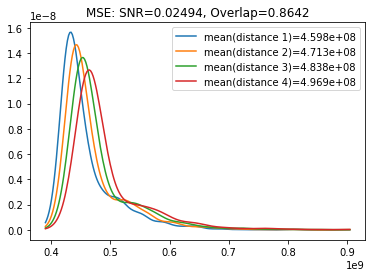

In [238]:
losses = lossByDist(imaging_id,4,volume_loss,"MSE",512)

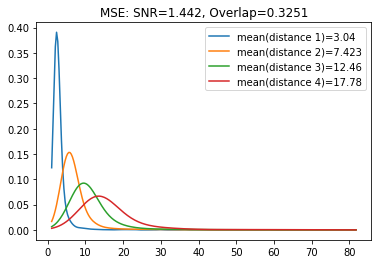

In [254]:
losses = lossByDist(cnmf_id,4,volume_loss,"MSE",512)

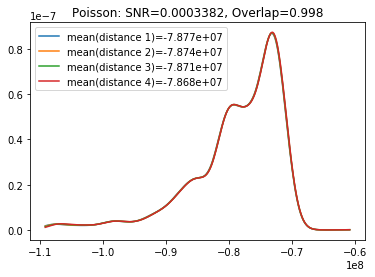

In [239]:
loss_func = partial(volume_loss, loss=nn.PoissonNLLLoss(log_input=False,full=False,reduce=False))
losses = lossByDist(imaging_id,4,loss_func,"Poisson",512)

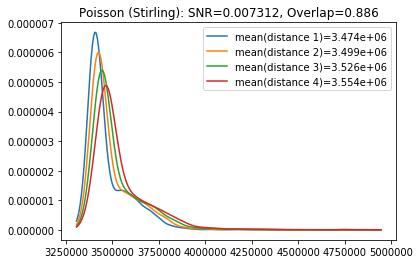

In [168]:
loss_func = partial(volume_loss, loss=nn.PoissonNLLLoss(log_input=False,full=True,reduce=False))
losses = lossByDist(imaging_id,4,loss_func,"Poisson (Stirling)",256)

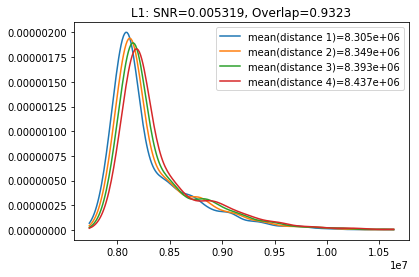

In [169]:
loss_func = partial(volume_loss, loss=nn.L1Loss(reduce=False))
losses = lossByDist(imaging_id,4,loss_func,"L1",256)

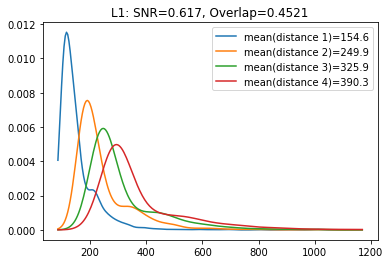

In [256]:
loss_func = partial(volume_loss, loss=nn.L1Loss(reduce=False))
losses = lossByDist(cnmf_id,4,loss_func,"L1",256)

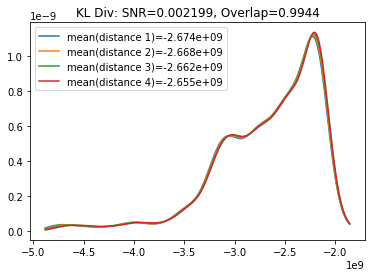

In [240]:
loss_func = partial(volume_loss, loss=nn.KLDivLoss(reduce=False))
losses = lossByDist(imaging_id,4,loss_func,"KL Div",256)

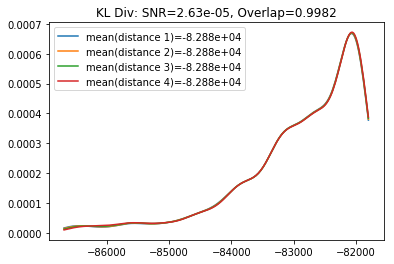

In [257]:
loss_func = partial(volume_loss, loss=nn.KLDivLoss(reduce=False))
losses = lossByDist(cnmf_id,4,loss_func,"KL Div",256)

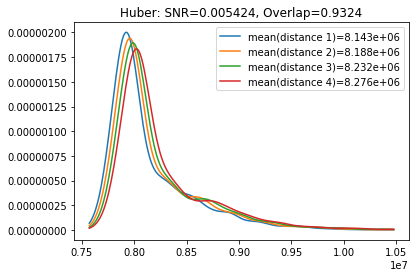

In [234]:
loss_func = partial(volume_loss, loss=nn.SmoothL1Loss(reduce=False))
losses = lossByDist(imaging_id,4,loss_func,"Huber",256)

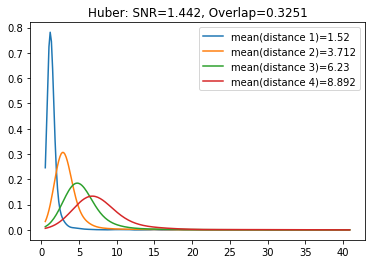

In [258]:
loss_func = partial(volume_loss, loss=nn.SmoothL1Loss(reduce=False))
losses = lossByDist(cnmf_id,4,loss_func,"Huber",256)

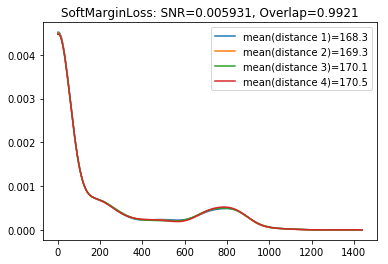

In [235]:
loss_func = partial(volume_loss, loss=nn.SoftMarginLoss(reduce=False))
losses = lossByDist(imaging_id,4,loss_func,"SoftMarginLoss",256)

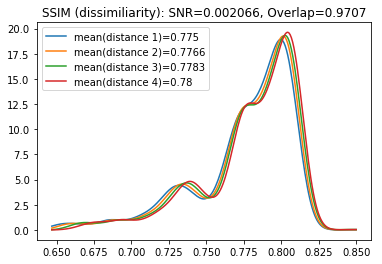

In [242]:
my_ssim = SSIM()
loss_func = lambda x,y: 1-my_ssim(x,y).view(1)
losses = lossByDist(imaging_id,4,loss_func,"SSIM (dissimiliarity)",1)

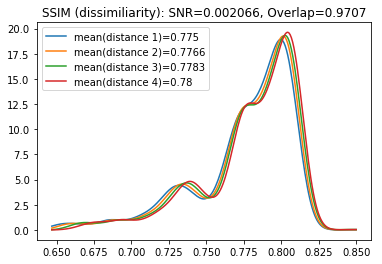

In [260]:
my_ssim = SSIM()
loss_func = lambda x,y: 1-my_ssim(x,y).view(1)
losses = lossByDist(imaging_id,4,loss_func,"SSIM (dissimiliarity)",1)

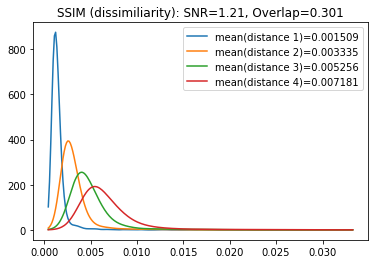

In [261]:
my_ssim = SSIM()
loss_func = lambda x,y: 1-my_ssim(x,y).view(1)
losses = lossByDist(cnmf_id,4,loss_func,"SSIM (dissimiliarity)",1)

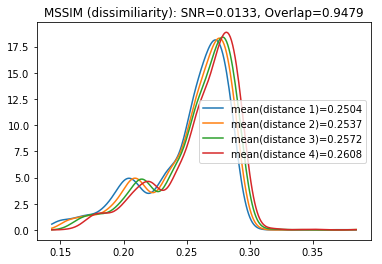

In [264]:
my_mssim = MSSSIM(channel=11)
loss_func = lambda x,y: 1-my_mssim(x,y).view(1)
losses = lossByDist(imaging_id,4,loss_func,"MSSIM (dissimiliarity)",1)

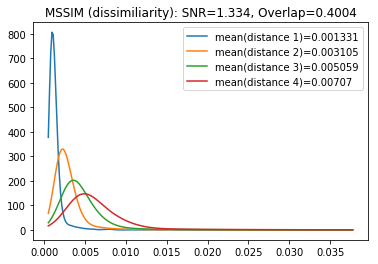

In [265]:
my_mssim = MSSSIM(channel=11)
loss_func = lambda x,y: 1-my_mssim(x,y).view(1)
losses = lossByDist(cnmf_id,4,loss_func,"MSSIM (dissimiliarity)",1)